#### Prep

In [0]:
# set working directory
import os
import sys
project_root = '/Users/kgedney/Documents/georgetown/anly580/anly580-wine-project'
os.chdir(project_root)

In [0]:
# install packages
import numpy as np
import pandas as pd


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [0]:
# kaggle load data 
# ref: https://www.kaggle.com/zynicide/wine-reviews#winemag-data_first150k.csv
df_full = pd.read_csv('data/winemag-data_first150k.csv', encoding='utf8')

In [0]:
df_full.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'variety', 'winery'],
      dtype='object')

#### Google Colab Prep

In [0]:
# install packages
import numpy as np
import pandas as pd


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [164]:
# get data from Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [95]:
# manually add file from local to drive
df_full = pd.read_csv('winemag-data_first150k.csv', encoding='utf8')
df_full.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


#### Define Classes

In [0]:
# select wines with over 1050 tasting notes (to make an even 30 varities)
variety_counts = pd.DataFrame(df_full['variety'].value_counts())
varieties      = list(variety_counts.index[variety_counts['variety'] > 1000])

# remove blends
varieties.remove('Red Blend')
varieties.remove('White Blend')
varieties.remove('Sparkling Blend')

len(varieties)

In [0]:
df = df_full[df_full['variety'].isin(varieties)]

In [114]:
df.variety.value_counts()

Chardonnay                       14482
Pinot Noir                       14291
Cabernet Sauvignon               12800
Bordeaux-style Red Blend          7347
Sauvignon Blanc                   6320
Syrah                             5825
Riesling                          5524
Merlot                            5070
Zinfandel                         3799
Sangiovese                        3345
Malbec                            3208
Rosé                              2817
Tempranillo                       2556
Nebbiolo                          2241
Portuguese Red                    2216
Shiraz                            1970
Corvina, Rondinella, Molinara     1682
Rhône-style Red Blend             1505
Barbera                           1365
Pinot Gris                        1365
Cabernet Franc                    1363
Sangiovese Grosso                 1346
Pinot Grigio                      1305
Viognier                          1263
Bordeaux-style White Blend        1261
Champagne Blend          

In [115]:
# map classes to integers
df['variety_code'] = pd.Categorical(df.variety).codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#df[['variety','variety_code']]

In [0]:
# set classes
x = df.description.values
y = df.variety_code.values

In [0]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=522)

#### Baseline: Linear SVM

In [118]:
# majority class prediction
np.mean(y_test == 6)

0.1315177227316272

In [119]:
# data preprocess
tfidf_vec   = TfidfVectorizer()
x_train_vec = tfidf_vec.fit_transform(x_train)
x_test_vec  = tfidf_vec.transform(x_test)
x_train_vec.shape

(87683, 24457)

In [120]:
# fit model
from sklearn.svm import LinearSVC
clf             = LinearSVC().fit(x_train_vec, y_train)
predicted       = clf.predict(x_test_vec)
predicted_score = clf.decision_function(x_test_vec)
print('accuracy', metrics.accuracy_score(y_test, predicted))

accuracy 0.827927558049359


In [121]:
# grid search on C
def fit_svc(C=1):
    clf             = LinearSVC(C=C).fit(x_train_vec, y_train)
    predicted       = clf.predict(x_test_vec)
    predicted_score = clf.decision_function(x_test_vec)
    return metrics.accuracy_score(y_test, predicted)

for C in [0.1, 0.5, 1, 2, 4, 8]:
    print(fit_svc(C=C))


0.7747821723461521
0.815519364992473
0.827927558049359
0.8339035627936682
0.8335386159390539
0.8319419734501163


#### Preprocess Data for Keras Models

In [0]:
import keras
from keras import optimizers
import tensorflow as tf

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Model, Sequential
from keras.layers import Input, Dense, CuDNNLSTM, LSTM, Embedding, Bidirectional, GlobalAveragePooling1D, Conv1D, Activation, Flatten, Dropout, MaxPooling1D, Embedding, GlobalMaxPooling1D

from keras.layers.core import Dense, Dropout

In [124]:
# data preprocess
x = df.description.values
y = df.variety_code.values

# create sequences
max_features = 25000
tokenizer    = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x)
x_sequences  = tokenizer.texts_to_sequences(x)

# pad each sequence to be max length
maxlen = max(len(x) for x in x_sequences)
print(maxlen)
x_sequences = sequence.pad_sequences(x_sequences, maxlen)

136


In [201]:
pd.value_counts(y)

6     14482
14    14291
4     12800
1      7347
22     6320
24     5825
18     5524
10     5070
27     3799
20     3345
9      3208
19     2817
25     2556
11     2241
16     2216
23     1970
7      1682
17     1505
13     1365
0      1365
3      1363
21     1346
12     1305
26     1263
2      1261
5      1238
15     1058
8      1042
dtype: int64

In [0]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.20, random_state=22)

#### 1. Simple Model

In [0]:
model1 = Sequential()
model1.add(Embedding(input_dim=max_features,
                    output_dim=256))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model1.add(GlobalAveragePooling1D())
model1.add(Dropout(0.5))

model1.add(Dense(100, activation="softmax"))

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model1.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [145]:
history1 = model1.fit(x_train, y_train,
            batch_size=512,
            epochs=22,
            validation_data=(x_test, y_test))

Train on 87683 samples, validate on 21921 samples
Epoch 1/22
87683/87683 [==============================] - 5s 52us/step - loss: 2.3754 - acc: 0.3520 - val_loss: 1.4760 - val_acc: 0.5710
Epoch 2/22
87683/87683 [==============================] - 3s 37us/step - loss: 1.1739 - acc: 0.6619 - val_loss: 0.9509 - val_acc: 0.7214
Epoch 3/22
87683/87683 [==============================] - 3s 37us/step - loss: 0.8283 - acc: 0.7579 - val_loss: 0.7825 - val_acc: 0.7656
Epoch 4/22
87683/87683 [==============================] - 3s 36us/step - loss: 0.6714 - acc: 0.8015 - val_loss: 0.7115 - val_acc: 0.7852
Epoch 5/22
87683/87683 [==============================] - 3s 36us/step - loss: 0.5740 - acc: 0.8299 - val_loss: 0.6670 - val_acc: 0.8012
Epoch 6/22
87683/87683 [==============================] - 3s 36us/step - loss: 0.5029 - acc: 0.8511 - val_loss: 0.6407 - val_acc: 0.8098
Epoch 7/22
87683/87683 [==============================] - 3s 36us/step - loss: 0.4432 - acc: 0.8693 - val_loss: 0.6312 - val_acc

In [142]:
print('accuracy', model1.evaluate(x_test, y_test)[1])

21921/21921 [==============================] - 1s 65us/step
accuracy 0.8428903790885452


In [132]:
print('train accuracy', model1.evaluate(x_train, y_train)[1])

87683/87683 [==============================] - 5s 62us/step
train accuracy 0.9673596934411459


#### 2. LSTM

In [0]:
# ref: https://keras.io/layers/recurrent/#cudnnlstm
# faster LSTM implementation

model2 = Sequential()
model2.add(Embedding(input_dim=max_features,
                     output_dim=128))
model2.add(CuDNNLSTM(128))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation="softmax"))

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model2.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [135]:
history2 = model2.fit(x_train, y_train,
            batch_size=512,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 87683 samples, validate on 21921 samples
Epoch 1/16
87683/87683 [==============================] - 14s 165us/step - loss: 2.3289 - acc: 0.3158 - val_loss: 1.3298 - val_acc: 0.5882
Epoch 2/16
87683/87683 [==============================] - 13s 149us/step - loss: 1.0701 - acc: 0.6824 - val_loss: 0.8765 - val_acc: 0.7382
Epoch 3/16
87683/87683 [==============================] - 13s 151us/step - loss: 0.7421 - acc: 0.7808 - val_loss: 0.7848 - val_acc: 0.7706
Epoch 4/16
87683/87683 [==============================] - 13s 152us/step - loss: 0.5787 - acc: 0.8279 - val_loss: 0.7526 - val_acc: 0.7920
Epoch 5/16
87683/87683 [==============================] - 13s 151us/step - loss: 0.4730 - acc: 0.8600 - val_loss: 0.7460 - val_acc: 0.8027
Epoch 6/16
87683/87683 [==============================] - 13s 151us/step - loss: 0.4084 - acc: 0.8783 - val_loss: 0.7651 - val_acc: 0.8050
Epoch 7/16
87683/87683 [==============================] - 13s 151us/step - loss: 0.3580 - acc: 0.8935 - val_loss: 0.

In [136]:
print('accuracy', model2.evaluate(x_test, y_test)[1])

21921/21921 [==============================] - 7s 313us/step
accuracy 0.8170703891245837


#### 3. Bidirectional LSTM

In [0]:
model3 = Sequential()
model3.add(Embedding(input_dim=max_features,
                     output_dim=128))
model3.add(Bidirectional(CuDNNLSTM(128)))
model3.add(Dropout(0.5))
model3.add(Dense(100, activation="softmax"))

model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model3.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [139]:
history3 = model3.fit(x_train, y_train,
            batch_size=512,
            epochs=20,
            validation_data=(x_test, y_test))

Train on 87683 samples, validate on 21921 samples
Epoch 1/20
87683/87683 [==============================] - 27s 305us/step - loss: 1.9903 - acc: 0.4142 - val_loss: 1.0667 - val_acc: 0.6767
Epoch 2/20
87683/87683 [==============================] - 25s 283us/step - loss: 0.8888 - acc: 0.7377 - val_loss: 0.7888 - val_acc: 0.7617
Epoch 3/20
87683/87683 [==============================] - 25s 280us/step - loss: 0.6310 - acc: 0.8122 - val_loss: 0.7106 - val_acc: 0.7929
Epoch 4/20
87683/87683 [==============================] - 25s 282us/step - loss: 0.4906 - acc: 0.8547 - val_loss: 0.6981 - val_acc: 0.8000
Epoch 5/20
87683/87683 [==============================] - 25s 282us/step - loss: 0.3985 - acc: 0.8819 - val_loss: 0.7086 - val_acc: 0.8145
Epoch 6/20
87683/87683 [==============================] - 25s 283us/step - loss: 0.3378 - acc: 0.8997 - val_loss: 0.7127 - val_acc: 0.8206
Epoch 7/20
87683/87683 [==============================] - 25s 281us/step - loss: 0.2889 - acc: 0.9145 - val_loss: 0.

In [140]:
print('accuracy', model3.evaluate(x_test, y_test)[1])

21921/21921 [==============================] - 11s 522us/step
accuracy 0.8325350120888646


#### Plots and Compare

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

In [147]:
# plot accuracy rates by author from best model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

y_pred1 = model1.predict_classes(x_test)
# print(classification_report(y_test, y_pred4))

cm = confusion_matrix(y_test, y_pred1) # only works with sparse
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracies = cm.diagonal()
accuracies

array([0.8778626 , 0.86810229, 0.77734375, 0.74538745, 0.82732968,
       0.77862595, 0.9287419 , 0.86931818, 0.80193237, 0.72115385,
       0.73770492, 0.90570175, 0.78059072, 0.73818182, 0.89303483,
       0.72246696, 0.79147982, 0.81333333, 0.88301887, 0.84798535,
       0.84921764, 0.90812721, 0.87032617, 0.81795511, 0.8042735 ,
       0.7983871 , 0.73877551, 0.85413929])

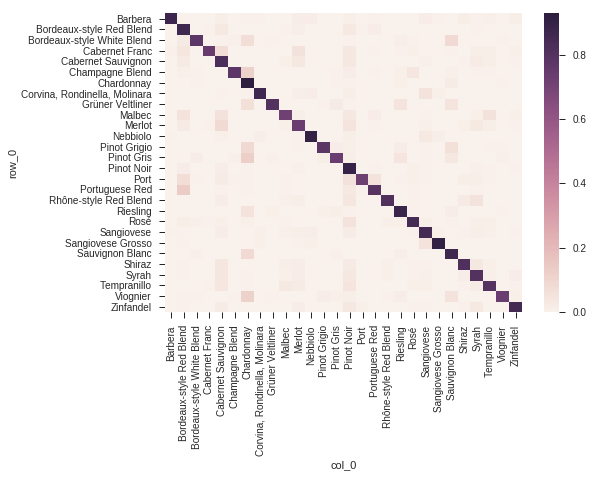

In [148]:
v_lookup = df[['variety_code', 'variety']].drop_duplicates().set_index('variety_code').to_dict()
v_lookup = v_lookup['variety']

y_test_name = np.array([v_lookup[y_code] for y_code in y_test])
y_pred_name = np.array([v_lookup[y_code] for y_code in y_pred1])

to_plot = pd.crosstab(y_test_name, y_pred_name, normalize='index')
sns.heatmap(to_plot)

In [0]:
v_labels = sorted(v_lookup.items(), key=lambda x: x[0])
v_labels = [vv[1] for vv in v_labels]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


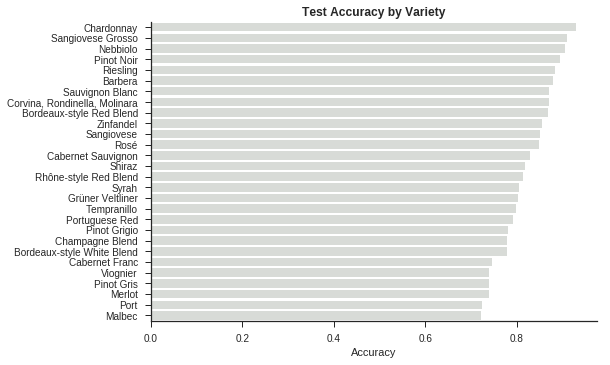

In [210]:
# plot accuracy by wine another way

acc_order = np.argsort(-accuracies) # get index to sort by

sns.barplot(y=np.array(v_labels)[acc_order], x=accuracies[acc_order], color='#d8dcd6')
plt.title('Test Accuracy by Variety', fontweight="bold")
plt.xlabel('Accuracy')
sns.despine()
plt.show()

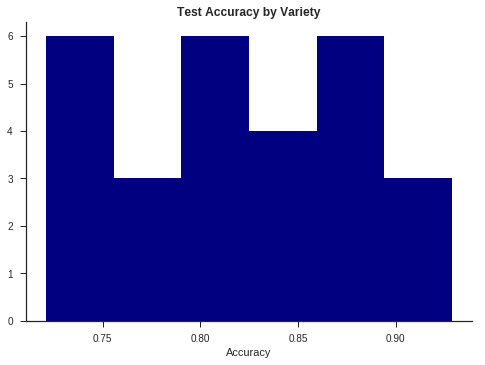

In [149]:
# plot as histogram
plt.hist(accuracies, bins=6, color='navy')
plt.title('Test Accuracy by Variety', fontweight="bold")
plt.xlabel('Accuracy')
sns.despine()
plt.show()

In [168]:
print(accuracies.max())
print(accuracies.argmax())

0.9287419024889192
6


TypeError: ignored

In [169]:
v_lookup

{0: 'Barbera',
 1: 'Bordeaux-style Red Blend',
 2: 'Bordeaux-style White Blend',
 3: 'Cabernet Franc',
 4: 'Cabernet Sauvignon',
 5: 'Champagne Blend',
 6: 'Chardonnay',
 7: 'Corvina, Rondinella, Molinara',
 8: 'Grüner Veltliner',
 9: 'Malbec',
 10: 'Merlot',
 11: 'Nebbiolo',
 12: 'Pinot Grigio',
 13: 'Pinot Gris',
 14: 'Pinot Noir',
 15: 'Port',
 16: 'Portuguese Red',
 17: 'Rhône-style Red Blend',
 18: 'Riesling',
 19: 'Rosé',
 20: 'Sangiovese',
 21: 'Sangiovese Grosso',
 22: 'Sauvignon Blanc',
 23: 'Shiraz',
 24: 'Syrah',
 25: 'Tempranillo',
 26: 'Viognier',
 27: 'Zinfandel'}

#### Plot Class Output

In [0]:
# plot of classes after being fit for the simple model
# ref: http://www.jacobsilterra.com/2017/05/06/classifying-text-with-keras-visualization/

# get values of last layer for each class and plot them to see which are most similar

#### Save Simple Model 

In [0]:
# save model
model1.save('/content/gdrive/My Drive/colab/wine_model_l.h5')

In [166]:
# save tokenizer
import pickle
tokenizer_path = '/content/gdrive/My Drive/colab/tokenizer.pkl'
pickle.dump(tokenizer, open(tokenizer_path, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

{0: 'Barbera',
 1: 'Bordeaux-style Red Blend',
 2: 'Bordeaux-style White Blend',
 3: 'Cabernet Franc',
 4: 'Cabernet Sauvignon',
 5: 'Champagne Blend',
 6: 'Chardonnay',
 7: 'Corvina, Rondinella, Molinara',
 8: 'Grüner Veltliner',
 9: 'Malbec',
 10: 'Merlot',
 11: 'Nebbiolo',
 12: 'Pinot Grigio',
 13: 'Pinot Gris',
 14: 'Pinot Noir',
 15: 'Port',
 16: 'Portuguese Red',
 17: 'Rhône-style Red Blend',
 18: 'Riesling',
 19: 'Rosé',
 20: 'Sangiovese',
 21: 'Sangiovese Grosso',
 22: 'Sauvignon Blanc',
 23: 'Shiraz',
 24: 'Syrah',
 25: 'Tempranillo',
 26: 'Viognier',
 27: 'Zinfandel'}

In [202]:
v_lookup

{0: 'Barbera',
 1: 'Bordeaux-style Red Blend',
 2: 'Bordeaux-style White Blend',
 3: 'Cabernet Franc',
 4: 'Cabernet Sauvignon',
 5: 'Champagne Blend',
 6: 'Chardonnay',
 7: 'Corvina, Rondinella, Molinara',
 8: 'Grüner Veltliner',
 9: 'Malbec',
 10: 'Merlot',
 11: 'Nebbiolo',
 12: 'Pinot Grigio',
 13: 'Pinot Gris',
 14: 'Pinot Noir',
 15: 'Port',
 16: 'Portuguese Red',
 17: 'Rhône-style Red Blend',
 18: 'Riesling',
 19: 'Rosé',
 20: 'Sangiovese',
 21: 'Sangiovese Grosso',
 22: 'Sauvignon Blanc',
 23: 'Shiraz',
 24: 'Syrah',
 25: 'Tempranillo',
 26: 'Viognier',
 27: 'Zinfandel'}